<a href="https://colab.research.google.com/github/sada1908/edyoda_mldl/blob/main/edyoda_MLAssign_ScaleCluster_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # E-commerce Customer Segmentation: The Impact of Feature Scaling on Clustering
#
# This notebook demonstrates the critical role of feature scaling in clustering algorithms. We'll use a synthetic e-commerce dataset with features of vastly different scales and a few outliers. Our goal is to segment customers using K-means clustering and evaluate how different scaling methods affect the quality of the resulting clusters.
#
# We'll follow these steps:
#
# 1.  **Data Preparation**: Create and examine a synthetic dataset.
# 2.  **Standard Scaling**: Transform data to a zero mean and unit variance.
# 3.  **MinMax Scaling**: Scale data to a fixed range, typically `[0, 1]`.
# 4.  **Robust Scaling**: Use median and interquartile range to handle outliers effectively.
# 5.  **Clustering Validation**: Apply K-means to each scaled dataset and compare the results using the Silhouette score.
#

# --- Code Block: Step 1 - Data Preparation ---
# ## Step 1: Data Preparation
# We'll start by generating a synthetic dataset that mimics e-commerce customer data. It will include features with different scales and a few deliberate outliers to test our scaling methods.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
# Generate a synthetic dataset with diverse scales
np.random.seed(42)
n_customers = 500
data = {
    'PurchaseFrequency': np.random.poisson(3, n_customers), # Low values, small scale
    'AverageOrderValue': np.random.gamma(20, 50, n_customers) + 100, # Large values, large scale
    'RecencyDays': np.random.exponential(30, n_customers) + 1 # Mixed values, moderate scale
}

In [4]:
df = pd.DataFrame(data)
df.head()

,PurchaseFrequency,AverageOrderValue,RecencyDays
0,4,1114.904810,16.276573
1,1,741.020906,55.940268
2,3,983.574027,7.267628
3,3,770.422077,34.484398
4,2,1201.669742,114.176904


In [5]:
# convert ordervalue to 1 decimal point and recencydays to integer
df['AverageOrderValue'] = df['AverageOrderValue'].round(1)
df['RecencyDays'] = df['RecencyDays'].astype(int)

In [6]:
# Add some outliers to demonstrate RobustScaler's advantage
df.loc[df.sample(5).index, 'AverageOrderValue'] *= 5
df.loc[df.sample(5).index, 'RecencyDays'] = 200 # A few very old customers

In [7]:
print("Initial Dataset Head:")
print(df.head())
print("\nInitial Dataset Descriptive Statistics:")
print(df.describe())

Initial Dataset Head:
   PurchaseFrequency  AverageOrderValue  RecencyDays
0                  4             1114.9           16
1                  1              741.0           55
2                  3              983.6            7
3                  3              770.4           34
4                  2             1201.7          114

Initial Dataset Descriptive Statistics:
       PurchaseFrequency  AverageOrderValue  RecencyDays
count         500.000000         500.000000   500.000000
mean            2.940000        1140.400800    31.584000
std             1.778405         482.999093    33.938512
min             0.000000         554.300000     1.000000
25%             2.000000         946.750000     9.000000
50%             3.000000        1094.550000    22.000000
75%             4.000000        1239.725000    42.000000
max             9.000000        6339.000000   205.000000


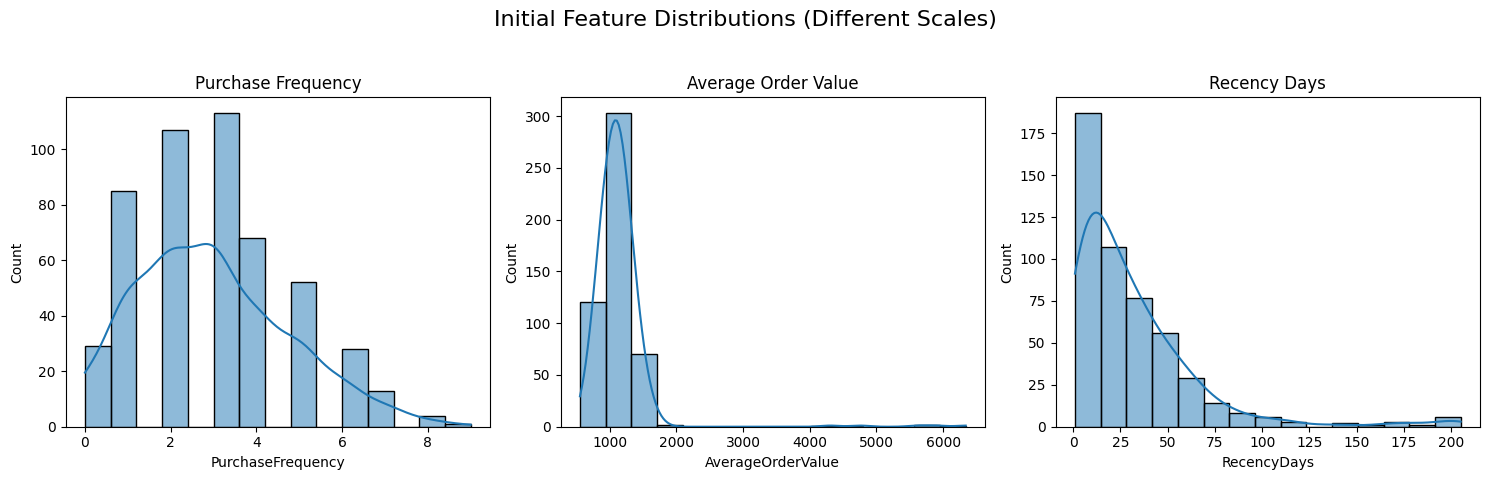

In [8]:
# Visualize the initial scale differences
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['PurchaseFrequency'], bins=15, kde=True)
plt.title('Purchase Frequency')
plt.subplot(1, 3, 2)
sns.histplot(df['AverageOrderValue'], bins=15, kde=True)
plt.title('Average Order Value')
plt.subplot(1, 3, 3)
sns.histplot(df['RecencyDays'], bins=15, kde=True)
plt.title('Recency Days')
plt.suptitle('Initial Feature Distributions (Different Scales)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
# --- Markdown Block: Step 2 - Standard Scaling ---
# ## Step 2: Standard Scaling
# **StandardScaler** transforms features so they have a mean of 0 and a standard deviation of 1. It is most appropriate when the data is roughly normally distributed and does not contain significant outliers, as the calculation of the mean and standard deviation can be heavily influenced by extreme values. This method is a good default choice for many machine learning algorithms, including K-means.

# --- Code Block: Step 2 - Standard Scaling Code ---

In [10]:
# --- Code Block: Step 2 - Standard Scaling Code ---
# Apply Standard Scaling to the dataframe
scaler_standard = StandardScaler()
df_standard_scaled = pd.DataFrame(scaler_standard.fit_transform(df), columns=df.columns)

In [11]:
df_standard_scaled.head()

,PurchaseFrequency,AverageOrderValue,RecencyDays
0,0.596637,-0.052850,-0.459643
1,-1.091957,-0.827746,0.690645
2,0.033772,-0.324965,-0.725094
3,0.033772,-0.766816,0.071259
4,-0.529093,0.127041,2.430824


In [12]:
print("Standard Scaled Data Descriptive Statistics:")
print(df_standard_scaled.describe())

Standard Scaled Data Descriptive Statistics:
       PurchaseFrequency  AverageOrderValue  RecencyDays
count       5.000000e+02       5.000000e+02   500.000000
mean        7.105427e-17      -2.451372e-16     0.000000
std         1.001002e+00       1.001002e+00     1.001002
min        -1.654822e+00      -1.214677e+00    -0.902062
25%        -5.290928e-01      -4.013356e-01    -0.666105
50%         3.377188e-02      -9.502444e-02    -0.282676
75%         5.966365e-01       2.058465e-01     0.307215
max         3.410960e+00       1.077394e+01     5.114829


In [13]:
# --- Markdown Block: Step 3 - MinMax Scaling ---
# ## Step 3: MinMax Scaling
# **MinMaxScaler** scales features to a fixed range, typically `[0, 1]`. This method is particularly useful for algorithms that do not assume a Gaussian distribution of the data, such as neural networks, or when you need to preserve the relative relationships between data points more than their absolute values.
#
# Comparing the two, Standard Scaling is about centering the data, while MinMax Scaling is about confining it to a specific box. The choice often depends on the algorithm you're using and whether you need to handle outliers gracefully.

In [14]:
# --- Code Block: Step 3 - MinMax Scaling Code ---
# Apply MinMax Scaling to the dataframe
scaler_minmax = MinMaxScaler()
df_minmax_scaled = pd.DataFrame(scaler_minmax.fit_transform(df), columns=df.columns)

In [15]:
print("MinMax Scaled Data Descriptive Statistics:")
print(df_minmax_scaled.describe())

MinMax Scaled Data Descriptive Statistics:
       PurchaseFrequency  AverageOrderValue  RecencyDays
count         500.000000         500.000000   500.000000
mean            0.326667           0.101319     0.149922
std             0.197601           0.083496     0.166365
min             0.000000           0.000000     0.000000
25%             0.222222           0.067843     0.039216
50%             0.333333           0.093393     0.102941
75%             0.444444           0.118489     0.200980
max             1.000000           1.000000     1.000000


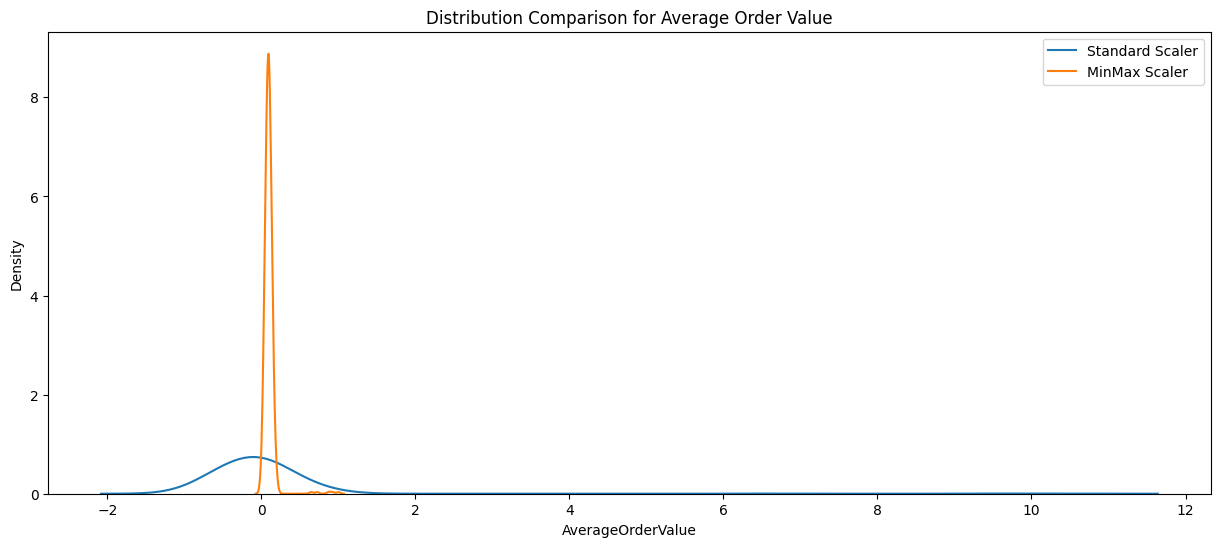

In [16]:
# Visualize the side-by-side comparison of scaled distributions
plt.figure(figsize=(15, 6))
sns.kdeplot(df_standard_scaled['AverageOrderValue'], label='Standard Scaler')
sns.kdeplot(df_minmax_scaled['AverageOrderValue'], label='MinMax Scaler')
plt.title('Distribution Comparison for Average Order Value')
plt.legend()
plt.show()

In [17]:
# --- Markdown Block: Step 4 - Robust Scaling ---
# ## Step 4: Robust Scaling
# **RobustScaler** is designed for datasets with outliers. Instead of using the mean and standard deviation, it uses the median and the interquartile range (IQR) for scaling. This makes it much less susceptible to the influence of outliers.
#
# As you can see in the boxplots below, the outliers are visible in the original and Standard Scaled data, but RobustScaler effectively compresses the main body of the data without completely removing the outliers' influence, making it a better choice for clustering when outliers are a concern.

In [18]:
# --- Code Block: Step 4 - Robust Scaling Code ---
# Apply Robust Scaling to the dataframe
scaler_robust = RobustScaler()
df_robust_scaled = pd.DataFrame(scaler_robust.fit_transform(df), columns=df.columns)

In [19]:
print("Robust Scaled Data Descriptive Statistics:")
print(df_robust_scaled.describe())

Robust Scaled Data Descriptive Statistics:
       PurchaseFrequency  AverageOrderValue  RecencyDays
count         500.000000       5.000000e+02   500.000000
mean           -0.030000       1.565007e-01     0.290424
std             0.889203       1.648602e+00     1.028440
min            -1.500000      -1.844014e+00    -0.636364
25%            -0.500000      -5.044799e-01    -0.393939
50%             0.000000      -3.880360e-16     0.000000
75%             0.500000       4.955201e-01     0.606061
max             3.000000       1.790067e+01     5.545455


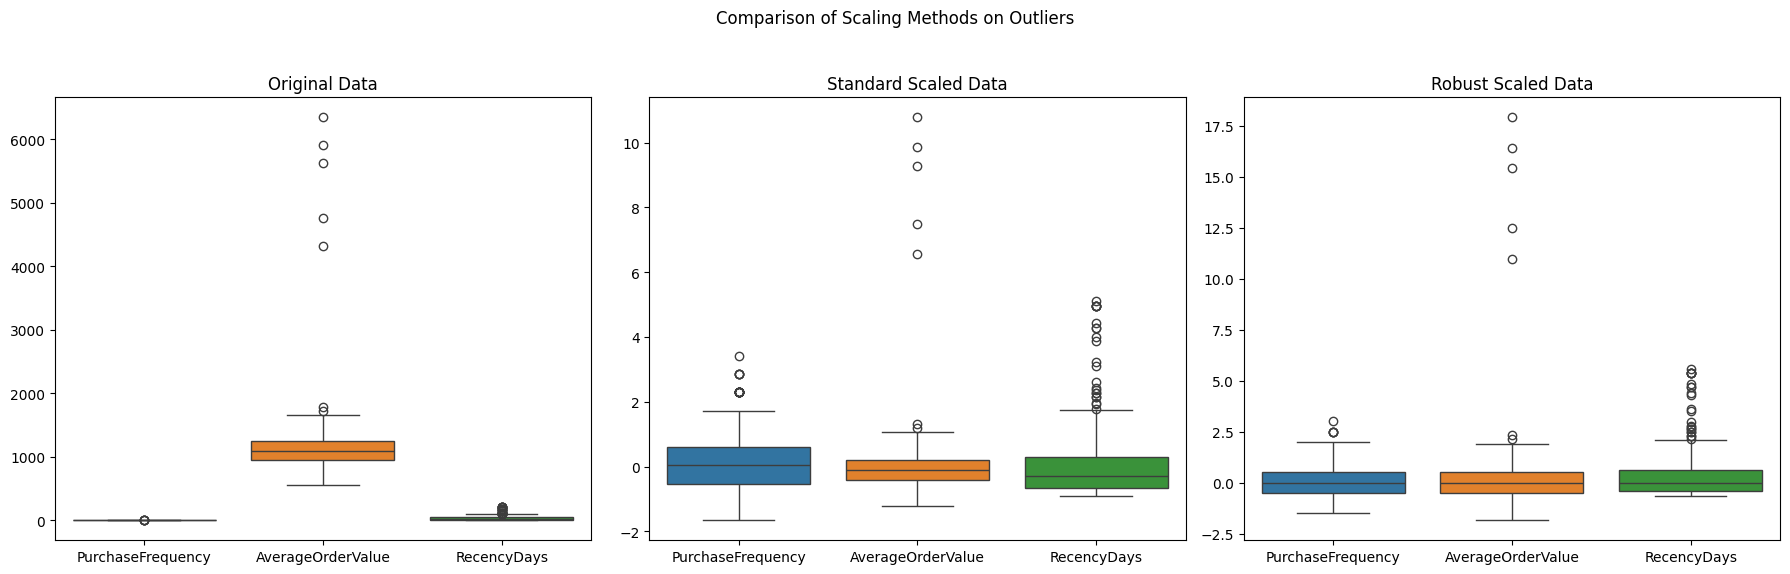

In [20]:
# Visualize the effect of scaling on outliers using boxplots
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.boxplot(data=df)
plt.title('Original Data')
plt.subplot(1, 3, 2)
sns.boxplot(data=df_standard_scaled)
plt.title('Standard Scaled Data')
plt.subplot(1, 3, 3)
sns.boxplot(data=df_robust_scaled)
plt.title('Robust Scaled Data')
plt.suptitle('Comparison of Scaling Methods on Outliers')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [21]:
# --- Markdown Block: Step 5 - Clustering Validation ---
# ## Step 5: Clustering Validation
# Now we'll apply K-means clustering with `k=5` to each of our scaled datasets. We will evaluate the performance of each scaling method using the Silhouette Score, a metric that measures how similar an object is to its own cluster compared to other clusters. A higher Silhouette Score indicates better-defined clusters.

In [22]:
# --- Code Block: Step 5 - Clustering Validation Code ---
# Initialize the K-means model with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)

In [23]:
# Function to perform clustering and get the silhouette score
def get_silhouette_score(data, model):
    model.fit(data)
    score = silhouette_score(data, model.labels_)
    return score

## Finding Optimal Number of Clusters using the Elbow Method

We'll use the Elbow Method on the MinMax scaled data to help determine a more optimal number of clusters.

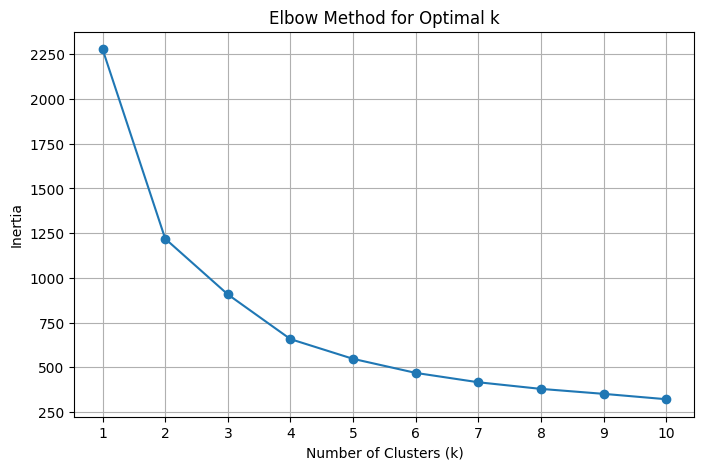

In [29]:
# Use the Elbow Method to find the optimal number of clusters
inertia = []
k_range = range(1, 11) # Test k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_robust_scaled.drop('Cluster', axis=1)) # Drop the existing cluster column
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [32]:
# Calculate scores for each scaled dataset with k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
score_standard_k3 = get_silhouette_score(df_standard_scaled.drop('Cluster', axis=1), kmeans_3)
score_minmax_k3 = get_silhouette_score(df_minmax_scaled.drop('Cluster', axis=1), kmeans_3)
score_robust_k3 = get_silhouette_score(df_robust_scaled.drop('Cluster', axis=1), kmeans_3)

In [33]:
# Present the findings in a summary table for k=3
summary_table_k3 = pd.DataFrame({
    'Scaling Method': ['StandardScaler', 'MinMaxScaler', 'RobustScaler'],
    'Silhouette Score (k=3)': [score_standard_k3, score_minmax_k3, score_robust_k3]
})

In [34]:
print("Clustering Performance Summary (k=3):")
print(summary_table_k3.sort_values(by='Silhouette Score (k=3)', ascending=False))

Clustering Performance Summary (k=3):
   Scaling Method  Silhouette Score (k=3)
2    RobustScaler                0.446993
1    MinMaxScaler                0.441309
0  StandardScaler                0.346052


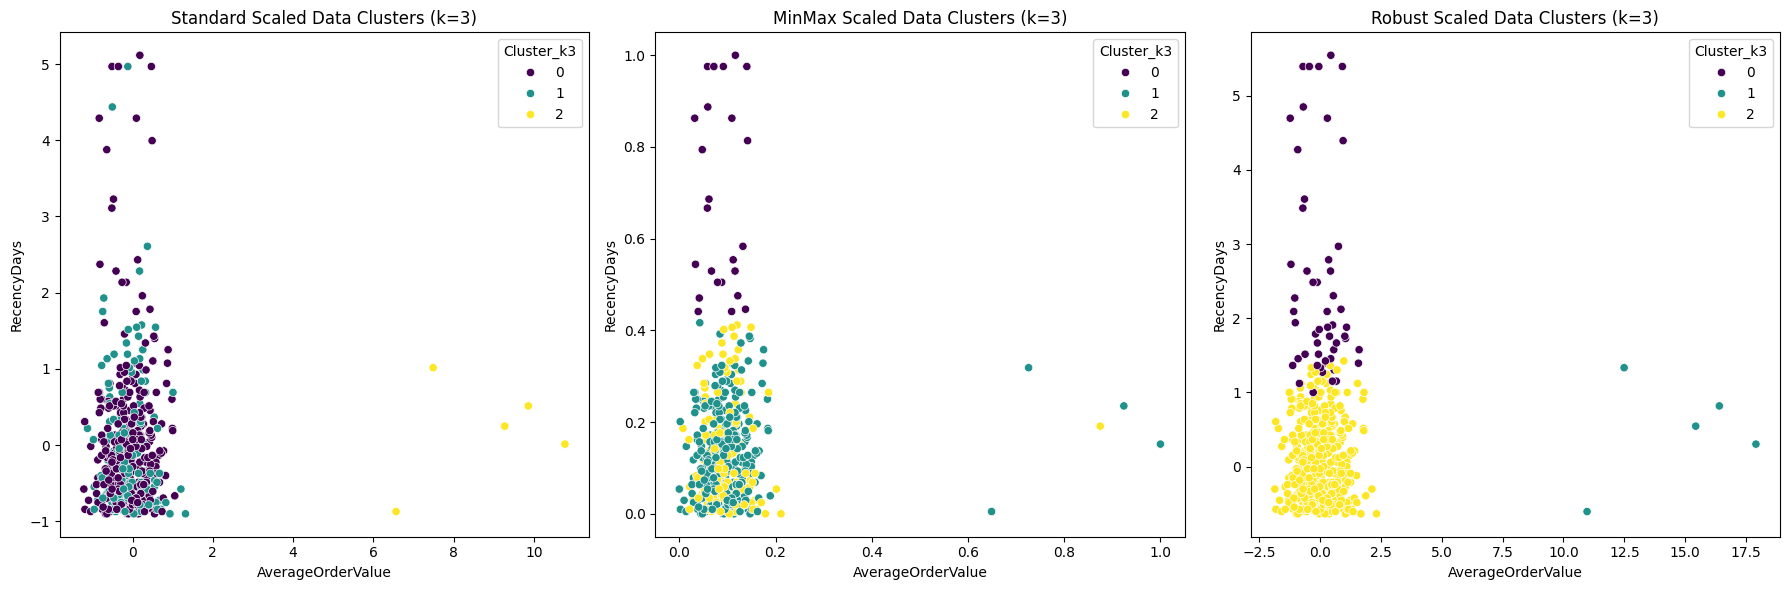

In [35]:
# Apply K-means to get cluster labels for each scaled dataset with k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
df_standard_scaled['Cluster_k3'] = kmeans_3.fit_predict(df_standard_scaled.drop('Cluster', axis=1))
df_minmax_scaled['Cluster_k3'] = kmeans_3.fit_predict(df_minmax_scaled.drop('Cluster', axis=1))
df_robust_scaled['Cluster_k3'] = kmeans_3.fit_predict(df_robust_scaled.drop('Cluster', axis=1))

# Visualize the clusters for each scaled dataset with k=3
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Standard Scaled
sns.scatterplot(data=df_standard_scaled, x='AverageOrderValue', y='RecencyDays', hue='Cluster_k3', palette='viridis', ax=axes[0])
axes[0].set_title('Standard Scaled Data Clusters (k=3)')

# MinMax Scaled
sns.scatterplot(data=df_minmax_scaled, x='AverageOrderValue', y='RecencyDays', hue='Cluster_k3', palette='viridis', ax=axes[1])
axes[1].set_title('MinMax Scaled Data Clusters (k=3)')

# Robust Scaled
sns.scatterplot(data=df_robust_scaled, x='AverageOrderValue', y='RecencyDays', hue='Cluster_k3', palette='viridis', ax=axes[2])
axes[2].set_title('Robust Scaled Data Clusters (k=3)')

plt.tight_layout()
plt.show()

In [31]:
kmeans_opt = 3
kmeans = KMeans(n_clusters=kmeans_opt, random_state=42, n_init=10)
df_robust_scaled['Cluster'] = kmeans.fit_predict(df_robust_scaled.drop('Cluster', axis=1))
opt_silhouette_score = silhouette_score(df_robust_scaled.drop('Cluster', axis=1), df_robust_scaled['Cluster'])
print(f"Optimal Number of Clusters (k): {kmeans_opt}")
print(f"Silhouette Score for Optimal k: {opt_silhouette_score}")

Optimal Number of Clusters (k): 3
Silhouette Score for Optimal k: 0.4469928118844256
